In [1]:
!pip install numpy pandas matplotlib seaborn nltk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
#conversion method found from https://stackoverflow.com/questions/30088006/loading-a-file-with-more-than-one-line-of-json-into-pandas
# read the entire file into a python array
with open('Sarcasm_Headlines_Dataset.json', 'r') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

data_json_str = "[" + ','.join(data) + "]"

df = pd.read_json(data_json_str)

In [3]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [5]:
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

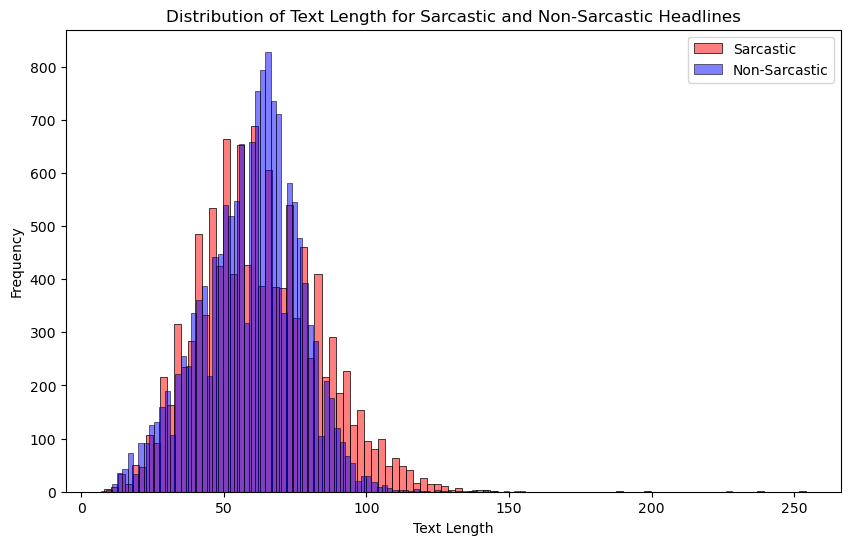

In [6]:
#Visualize the distribution of text length for sarcasm in the headlines
plt.figure(figsize=(10, 6))
sns.histplot(df[df['is_sarcastic'] == 1]['headline'].apply(len), label='Sarcastic', color='red', alpha=0.5)
sns.histplot(df[df['is_sarcastic'] == 0]['headline'].apply(len), label='Non-Sarcastic', color='blue', alpha=0.5)
plt.title('Distribution of Text Length for Sarcastic and Non-Sarcastic Headlines')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


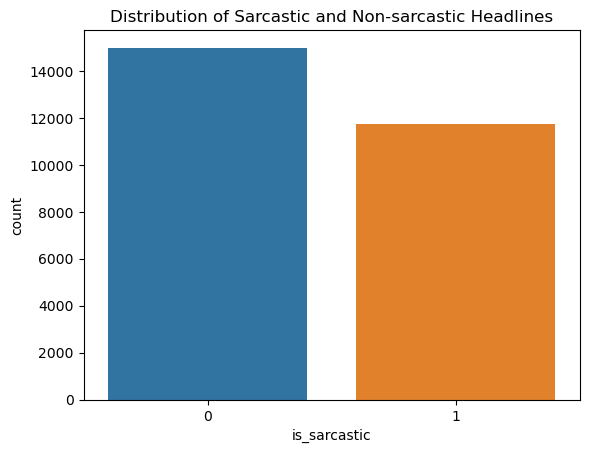

In [7]:
#Visualizes the distribution of sarcasm in headlines
sns.countplot(x='is_sarcastic', data=df)
plt.title('Distribution of Sarcastic and Non-sarcastic Headlines')
plt.show()

In [8]:
#df1 is a copy of the original data
df1 = df.copy()
df1.drop(columns='article_link', axis=1,  inplace=True)

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gwencampau/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
#Converts the headlines to lowercase and removes unnecessary characters and symbols
df1['headline'] = df1['headline'].str.lower()
df1['headline'] = df1['headline'].str.replace('[^\w\s]','')

#Tokenize the text into words
df1['Tokens'] = df1['headline'].apply(word_tokenize)
df1.head()

/var/folders/_8/plbxd2bd37s5lssm973rwmnr0000gn/T/ipykernel_51574/4059778083.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['headline'] = df1['headline'].str.replace('[^\w\s]','')


,headline,is_sarcastic,Tokens
0,former versace store clerk sues over secret bl...,0,"[former, versace, store, clerk, sues, over, se..."
1,the roseanne revival catches up to our thorny ...,0,"[the, roseanne, revival, catches, up, to, our,..."
2,mom starting to fear sons web series closest t...,1,"[mom, starting, to, fear, sons, web, series, c..."
3,boehner just wants wife to listen not come up ...,1,"[boehner, just, wants, wife, to, listen, not, ..."
4,jk rowling wishes snape happy birthday in the ...,0,"[jk, rowling, wishes, snape, happy, birthday, ..."


In [11]:
#Remove common words that don't carry much meaning to reduce noise
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df1['Tokens'] = df1['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gwencampau/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
#Apply lemmatization to each list of tokens in the Token column of the DataFrame
#Reduce words to their base form to improve textt analysis
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df1['Tokens'] = df1['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gwencampau/nltk_data...


In [14]:
df1.head()

,headline,is_sarcastic,Tokens
0,former versace store clerk sues over secret bl...,0,"[former, versace, store, clerk, sue, secret, b..."
1,the roseanne revival catches up to our thorny ...,0,"[roseanne, revival, catch, thorny, political, ..."
2,mom starting to fear sons web series closest t...,1,"[mom, starting, fear, son, web, series, closes..."
3,boehner just wants wife to listen not come up ...,1,"[boehner, want, wife, listen, come, alternativ..."
4,jk rowling wishes snape happy birthday in the ...,0,"[jk, rowling, wish, snape, happy, birthday, ma..."


# Modeling


In [16]:

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gwencampau/nltk_data...


In [18]:
sentiments = {}
for i, row in df1.iterrows():
    text = row['headline']
    row_id = i
    sentiments[row_id] = sia.polarity_scores(text)

In [19]:
sentiments

{0: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 1: {'neg': 0.272, 'neu': 0.576, 'pos': 0.152, 'compound': -0.3182},
 2: {'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'compound': -0.4939},
 3: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 4: {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.7351},
 5: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 6: {'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'compound': 0.5423},
 7: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 8: {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.2023},
 9: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 10: {'neg': 0.452, 'neu': 0.548, 'pos': 0.0, 'compound': -0.765},
 11: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 12: {'neg': 0.303, 'neu': 0.506, 'pos': 0.191, 'compound': -0.25},
 13: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 14: {'neg': 0.167, 'neu': 0.417, 'pos': 0.417, 'compound': 0.4588},
 15: {'neg': 0.314, 'neu': 0.686, 'pos': 0.0, '

In [22]:
vaders_df = pd.DataFrame(sentiments).T

In [29]:
negative = vaders_df['neg']
positive = vaders_df['pos']
neutral = vaders_df['neu']
df1=df1.join(negative)
df1=df1.join(positive)
df1=df1.join(neutral)

In [30]:
df1.head()

,headline,is_sarcastic,Tokens,neg,pos,neu
0,former versace store clerk sues over secret bl...,0,"[former, versace, store, clerk, sue, secret, b...",0.000,0.000,1.000
1,the roseanne revival catches up to our thorny ...,0,"[roseanne, revival, catch, thorny, political, ...",0.272,0.152,0.576
2,mom starting to fear sons web series closest t...,1,"[mom, starting, fear, son, web, series, closes...",0.198,0.000,0.802
3,boehner just wants wife to listen not come up ...,1,"[boehner, want, wife, listen, come, alternativ...",0.000,0.000,1.000
4,jk rowling wishes snape happy birthday in the ...,0,"[jk, rowling, wish, snape, happy, birthday, ma...",0.000,0.474,0.526


In [32]:
X = df1[['neg', 'pos','neu']]
y = df1['is_sarcastic']

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [36]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)

In [37]:
predicted = dtc.predict(X_test)
predicted
dtc.score(X_test, y_test)

0.551666042680644

In [41]:
df1.shape

(26709, 6)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.56      0.82      0.67      2953
           1       0.50      0.21      0.30      2389

    accuracy                           0.55      5342
   macro avg       0.53      0.52      0.48      5342
weighted avg       0.53      0.55      0.50      5342

